# Chronic occlusion

Mice were occluded at P7. After one month, cells isolated from occluded and open nostrils from each mouse were processed and analyzed separately.

In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import scanpy as sc

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from osn.olfr import olfr
from osn.preprocess import get_data_folders
from osn.viz import viz

In [3]:
sns.set_context("notebook")
sns.set(font_scale=1.5, style="ticks", palette="tab10")

# load adata and subselect ORs expressed in enough cells in each nostril

In [4]:
data_fold = get_data_folders()
ad_fn = data_fold.processed / "ChronicOccl_norm.h5ad"

OPEN = "L"
OCC = "R"
NOSTRILS = (OPEN, OCC)

OCC_L = "occluded"
OPEN_L = "open"
nostril_l = (OPEN_L, OCC_L)
DELTA = f"({OCC_L} - {OPEN_L})"

In [5]:
adata = sc.read(ad_fn)
print(adata)
display(adata.obs.groupby(['nostril']).orig_ident.value_counts().unstack())

AnnData object with n_obs × n_vars = 32568 × 29169
    obs: 'top_Olfr', 'orig_ident', 'source', 'nostril', 'time', 'ES_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_high_expr', 'log1p_total_counts_high_expr', 'pct_counts_high_expr', 'good_total_counts'
    var: 'mito', 'ribo', 'high_expr', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'X_nmf'


,ChronicOccl-1L,ChronicOccl-1R,ChronicOccl-2L,ChronicOccl-2R,ChronicOccl-3L,ChronicOccl-3R
nostril,,,,,,
L,5746,0,5726,0,5841,0
R,0,4961,0,5695,0,4599


In [6]:
SOURCE_THRESH = 4
df_OR, has_OR = olfr.get_OR_info(adata)

# ORs in enough cells in both nostrils
good_ORs, has_enough_ORs = olfr.filter_OR_source(df_OR, SOURCE_THRESH, col="nostril")
n_OR = len(good_ORs)
df_OR_keep = df_OR[has_enough_ORs]
print(
    f"Found {n_OR} ORs with at least {SOURCE_THRESH} cells per OR in each nostril; keeping {len(df_OR_keep)} OSNs"
)

# take mean across OSNs expressing each OR in each nostril
df_mean = df_OR_keep.groupby(['nostril', 'top_Olfr']).mean()
df_delta = df_mean.loc[OCC] - df_mean.loc[OPEN]

Found 797 ORs with at least 4 cells per OR in each nostril; keeping 30939 OSNs


# plot changes for each OSN subtype 

Text(0, 0.5, 'Occluded nostril')

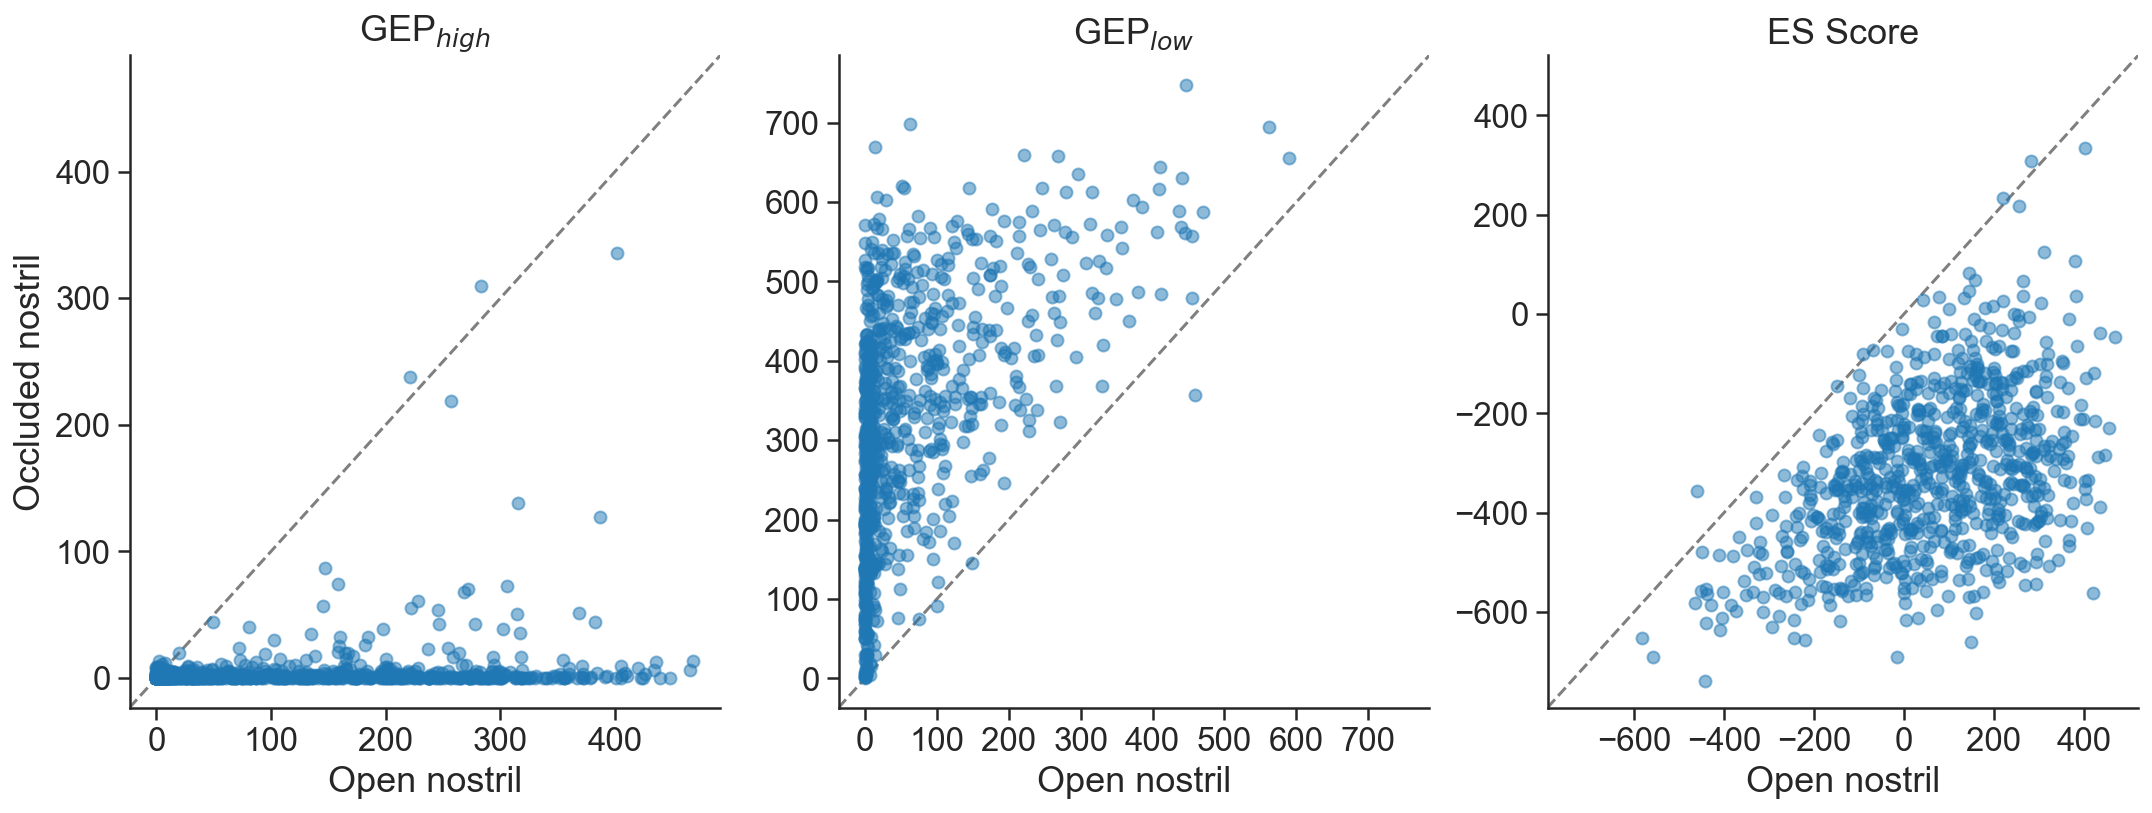

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

titles = [r"GEP$_{high}$", r"GEP$_{low}$", "ES Score"]
for ax, col, t in zip(axes, ["High", "Low", "ES_score"], titles):
    _df = df_mean[col]
    ax.scatter(_df.loc[OPEN], _df.loc[OCC], alpha=0.5)
    viz.adjust_lims(ax)
    ax.set_xlabel("Open nostril")
    ax.set_title(t)
sns.despine()
for ax in axes:
    diff = np.diff(ax.get_yticks()).mean()
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(diff))
axes[0].set_ylabel("Occluded nostril")

Text(0, 0.5, '∆ ES score (occluded - open)')

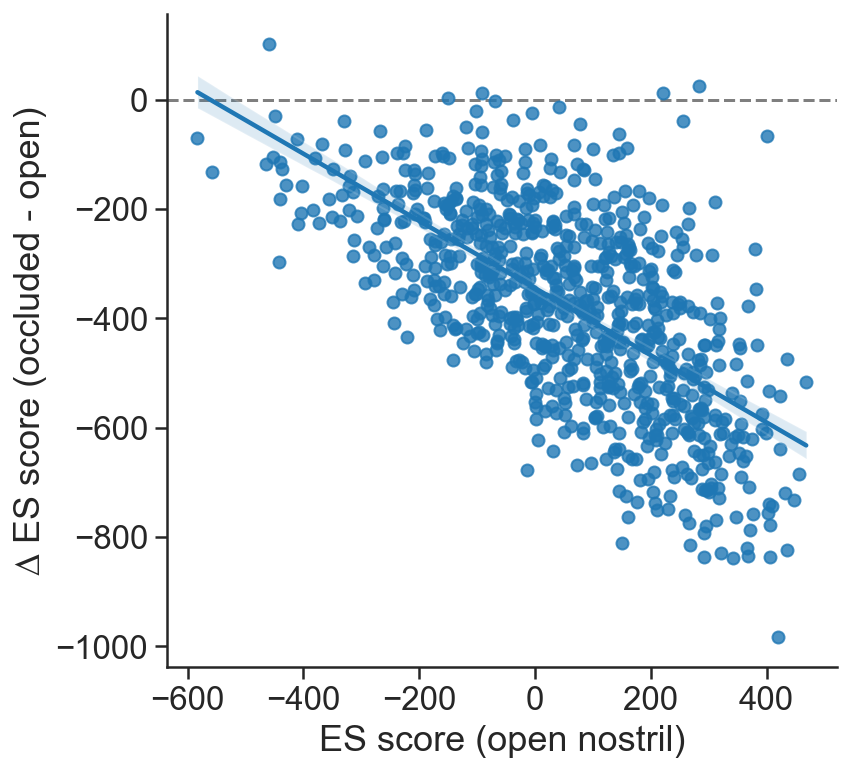

In [8]:
_x = df_mean['ES_score'].loc[OPEN]
_y = df_delta['ES_score']
fig, ax = plt.subplots(figsize=(6,6))
sns.regplot(x=_x, y=_y, ax=ax)
ax.axhline(0, ls="--", color="k", alpha=0.5, zorder=-5)
ax.set_xlabel("ES score (open nostril)")
sns.despine()
ax.set_ylabel(f"∆ ES score {DELTA}")

In [9]:
gep_use = adata.obsm["X_nmf"].columns[:7]
df_melt = df_delta[gep_use].reset_index().melt(id_vars=["top_Olfr"])
gep_array = np.array(gep_use)
colors = []
for g in gep_array:
    if np.in1d(g, ["High", "Low"]):
        colors.append(plt.cm.tab10(0))
    else:
        colors.append("0.7")

(-500.0, 550.0)

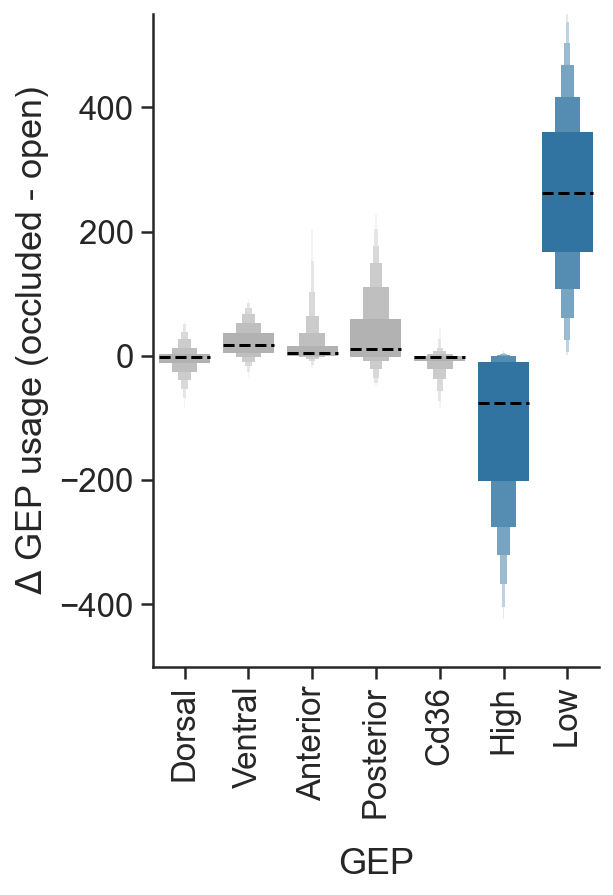

In [10]:
# distribution across OSN subtypes
fig, ax = plt.subplots(figsize=(4,6))
sns.boxenplot(data=df_melt, x="variable", y="value", order=gep_use, palette=colors)
viz.update_boxen(ax)
sns.despine()
plt.xticks(rotation=90);
ax.set_ylabel(rf"$\Delta$ GEP usage {DELTA}")
ax.set_xlabel("GEP", labelpad=15)
ax.set_ylim(-500, 550)